<a href="https://colab.research.google.com/github/AarnoStormborn/Tensorflow-Developer-Certification/blob/main/06_tensorflow_transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow: Scaling Up

In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [2]:
!nvidia-smi

Fri Feb  3 15:06:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-03 15:06:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-03 15:06:25 (76.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

## Data Acquisition

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-02-03 15:06:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.128, 64.233.183.128, 173.194.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   226MB/s    in 6.5s    

2023-02-03 15:06:32 (238 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
unzip_data("101_food_classes_10_percent.zip")

In [7]:
# Setup directories
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [8]:
# Walkthrough the directories
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/scallops'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/falafel'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/creme_brulee'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fish_and_chips'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '101_food_classes

## Load the Images

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMAGE_SIZE = (256,256)
BATCH_SIZE = 32

train_data = image_dataset_from_directory(train_dir,
                                          label_mode="categorical",
                                          batch_size=BATCH_SIZE,
                                          image_size=IMAGE_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         batch_size=BATCH_SIZE,
                                         image_size=IMAGE_SIZE,
                                         shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Steps to take

* Create ModelCheckpoint callback
* Create Data Augmentation layer
* Create Feature Extraction model using EfficientNetB0
* Evaluation on 15% test data

In [10]:
# ModelCheckpoint Callback
checkpoint_path = "scaling_up_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

### Model 0 - Feature Extraction

In [11]:
# Data Augmentation layer
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name='data_augmentation')

base_model = EfficientNetB0(include_top=False) # Setup Base Model
base_model.trainable = False # Freeze layers of the base model
inputs = layers.Input(shape=(256,256,3), name='input_layer') # Create inputs
x = augmentation(inputs) # Augmentation
x = base_model(x, training=False) # Pass augmented data into base model
x = layers.GlobalAveragePooling2D()(x) # GlobalAveragePooling layer
outputs = layers.Dense(101, activation='softmax', name='output_layer')(x) # Create Outputs
model_0 = Model(inputs, outputs) # Put everything together

# Compile the model
model_0.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_0 = model_0.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)),
                        callbacks=[create_tensorboard_callback("scaling_up", "model_0"), checkpoint_callback])

16705208/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: scaling_up/model_0/20230203-150653
Epoch 1/5
237/237 [==============================] - 129s 482ms/step - loss: 3.3296 - accuracy: 0.2882 - val_loss: 2.4886 - val_accuracy: 0.4645
Epoch 2/5
237/237 [==============================] - 96s 400ms/step - loss: 2.1664 - accuracy: 0.5065 - val_loss: 2.0217 - val_accuracy: 0.5180
Epoch 3/5
237/237 [==============================] - 87s 364ms/step - loss: 1.7887 - accuracy: 0.5760 - val_loss: 1.8523 - val_accuracy: 0.5312
Epoch 4/5
237/237 [==============================] - 79s 332ms/step - loss: 1.5604 - accuracy: 0.6294 - val_loss: 1.7779 - val_accuracy: 0.5456
Epoch 5/5
237/237 [==============================] - 75s 317ms/step - loss: 1.3928 - accuracy: 0.6602 - val_loss: 1.7452 - val_accuracy: 0.5485


In [12]:
# Evaluate on entire test set
model_0.evaluate(test_data)

790/790 [==============================] - 71s 90ms/step - loss: 1.5130 - accuracy: 0.6039


[1.5129677057266235, 0.6038811802864075]

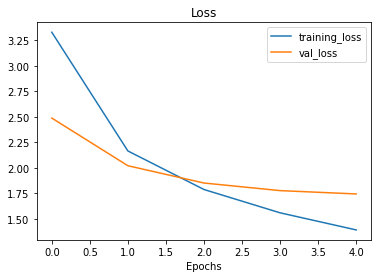

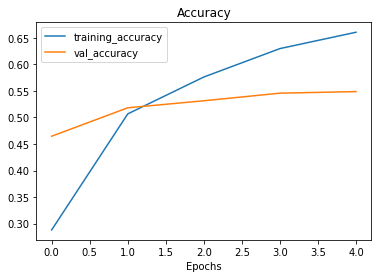

In [13]:
plot_loss_curves(history_0)

### Model 1 - Fine tuning

In [14]:
# Unfreeze last 5 layers of base model
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Recompile the model
model_0.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(0.0001),
                metrics=["accuracy"])

In [15]:
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

history_1 = model_0.fit(train_data,
            epochs=fine_tune_epochs,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.15 * len(test_data)),
            initial_epoch=history_0.epoch[-1],
            callbacks=[create_tensorboard_callback("scaling_up", "model_1")])

Saving TensorBoard log files to: scaling_up/model_1/20230203-151628
Epoch 5/10
237/237 [==============================] - 82s 314ms/step - loss: 1.1670 - accuracy: 0.6986 - val_loss: 1.6814 - val_accuracy: 0.5588
Epoch 6/10
237/237 [==============================] - 69s 291ms/step - loss: 1.0483 - accuracy: 0.7229 - val_loss: 1.6383 - val_accuracy: 0.5710
Epoch 7/10
237/237 [==============================] - 65s 273ms/step - loss: 0.9659 - accuracy: 0.7440 - val_loss: 1.6204 - val_accuracy: 0.5720
Epoch 8/10
237/237 [==============================] - 64s 270ms/step - loss: 0.8893 - accuracy: 0.7638 - val_loss: 1.6269 - val_accuracy: 0.5710
Epoch 9/10
237/237 [==============================] - 61s 256ms/step - loss: 0.8479 - accuracy: 0.7717 - val_loss: 1.6282 - val_accuracy: 0.5710
Epoch 10/10
237/237 [==============================] - 60s 251ms/step - loss: 0.7949 - accuracy: 0.7859 - val_loss: 1.6463 - val_accuracy: 0.5697


In [16]:
# Evaluate on whole test set
model_0.evaluate(test_data)

790/790 [==============================] - 71s 90ms/step - loss: 1.4060 - accuracy: 0.6241


[1.405955195426941, 0.6241188049316406]

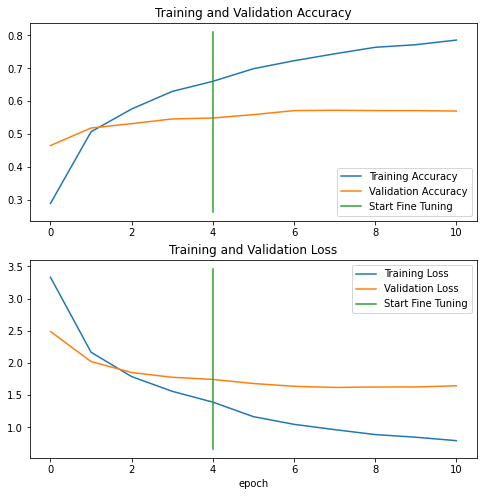

In [17]:
# Compare training
compare_historys(history_0, history_1)

## Saving and Loading Model

In [18]:
# Save to Google Drive
model_0.save("drive/MyDrive/tf_model/scaling_up.h5")

In [19]:
# Load model and evaluate
loaded_model = tf.keras.models.load_model("drive/MyDrive/tf_model/scaling_up.h5")
results = loaded_model.evaluate(test_data)

790/790 [==============================] - 73s 90ms/step - loss: 1.4060 - accuracy: 0.6241


## Evaluating performance of the Model

#### Reload data

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

train_data = image_dataset_from_directory(train_dir,
                                          label_mode="categorical",
                                          batch_size=BATCH_SIZE,
                                          image_size=IMAGE_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         batch_size=BATCH_SIZE,
                                         image_size=IMAGE_SIZE,
                                         shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [21]:
# Use another pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

--2023-02-03 15:26:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   170MB/s    in 0.3s    

2023-02-03 15:26:36 (170 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [22]:
# Load saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [23]:
# Evaluate
model.evaluate(test_data)

790/790 [==============================] - 63s 77ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

### Make Predictions with the Model

In [24]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 65s 81ms/step


In [25]:
pred_probs.shape

(25250, 101)

In [26]:
len(pred_probs[0])

101

In [27]:
# Let's get actual labels from test data
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # Labels are One Hot Encoded, hence argmax()
len(y_labels)

25250

In [28]:
y_pred = tf.argmax(pred_probs, axis=1)
len(y_pred)

25250

## Evaluating the Predictions

In [29]:
from sklearn.metrics import accuracy_score
sklearn_acc = accuracy_score(y_true=y_labels,
                            y_pred=y_pred)
sklearn_acc

0.6077623762376237

In [30]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [31]:
class_names = test_data.class_names

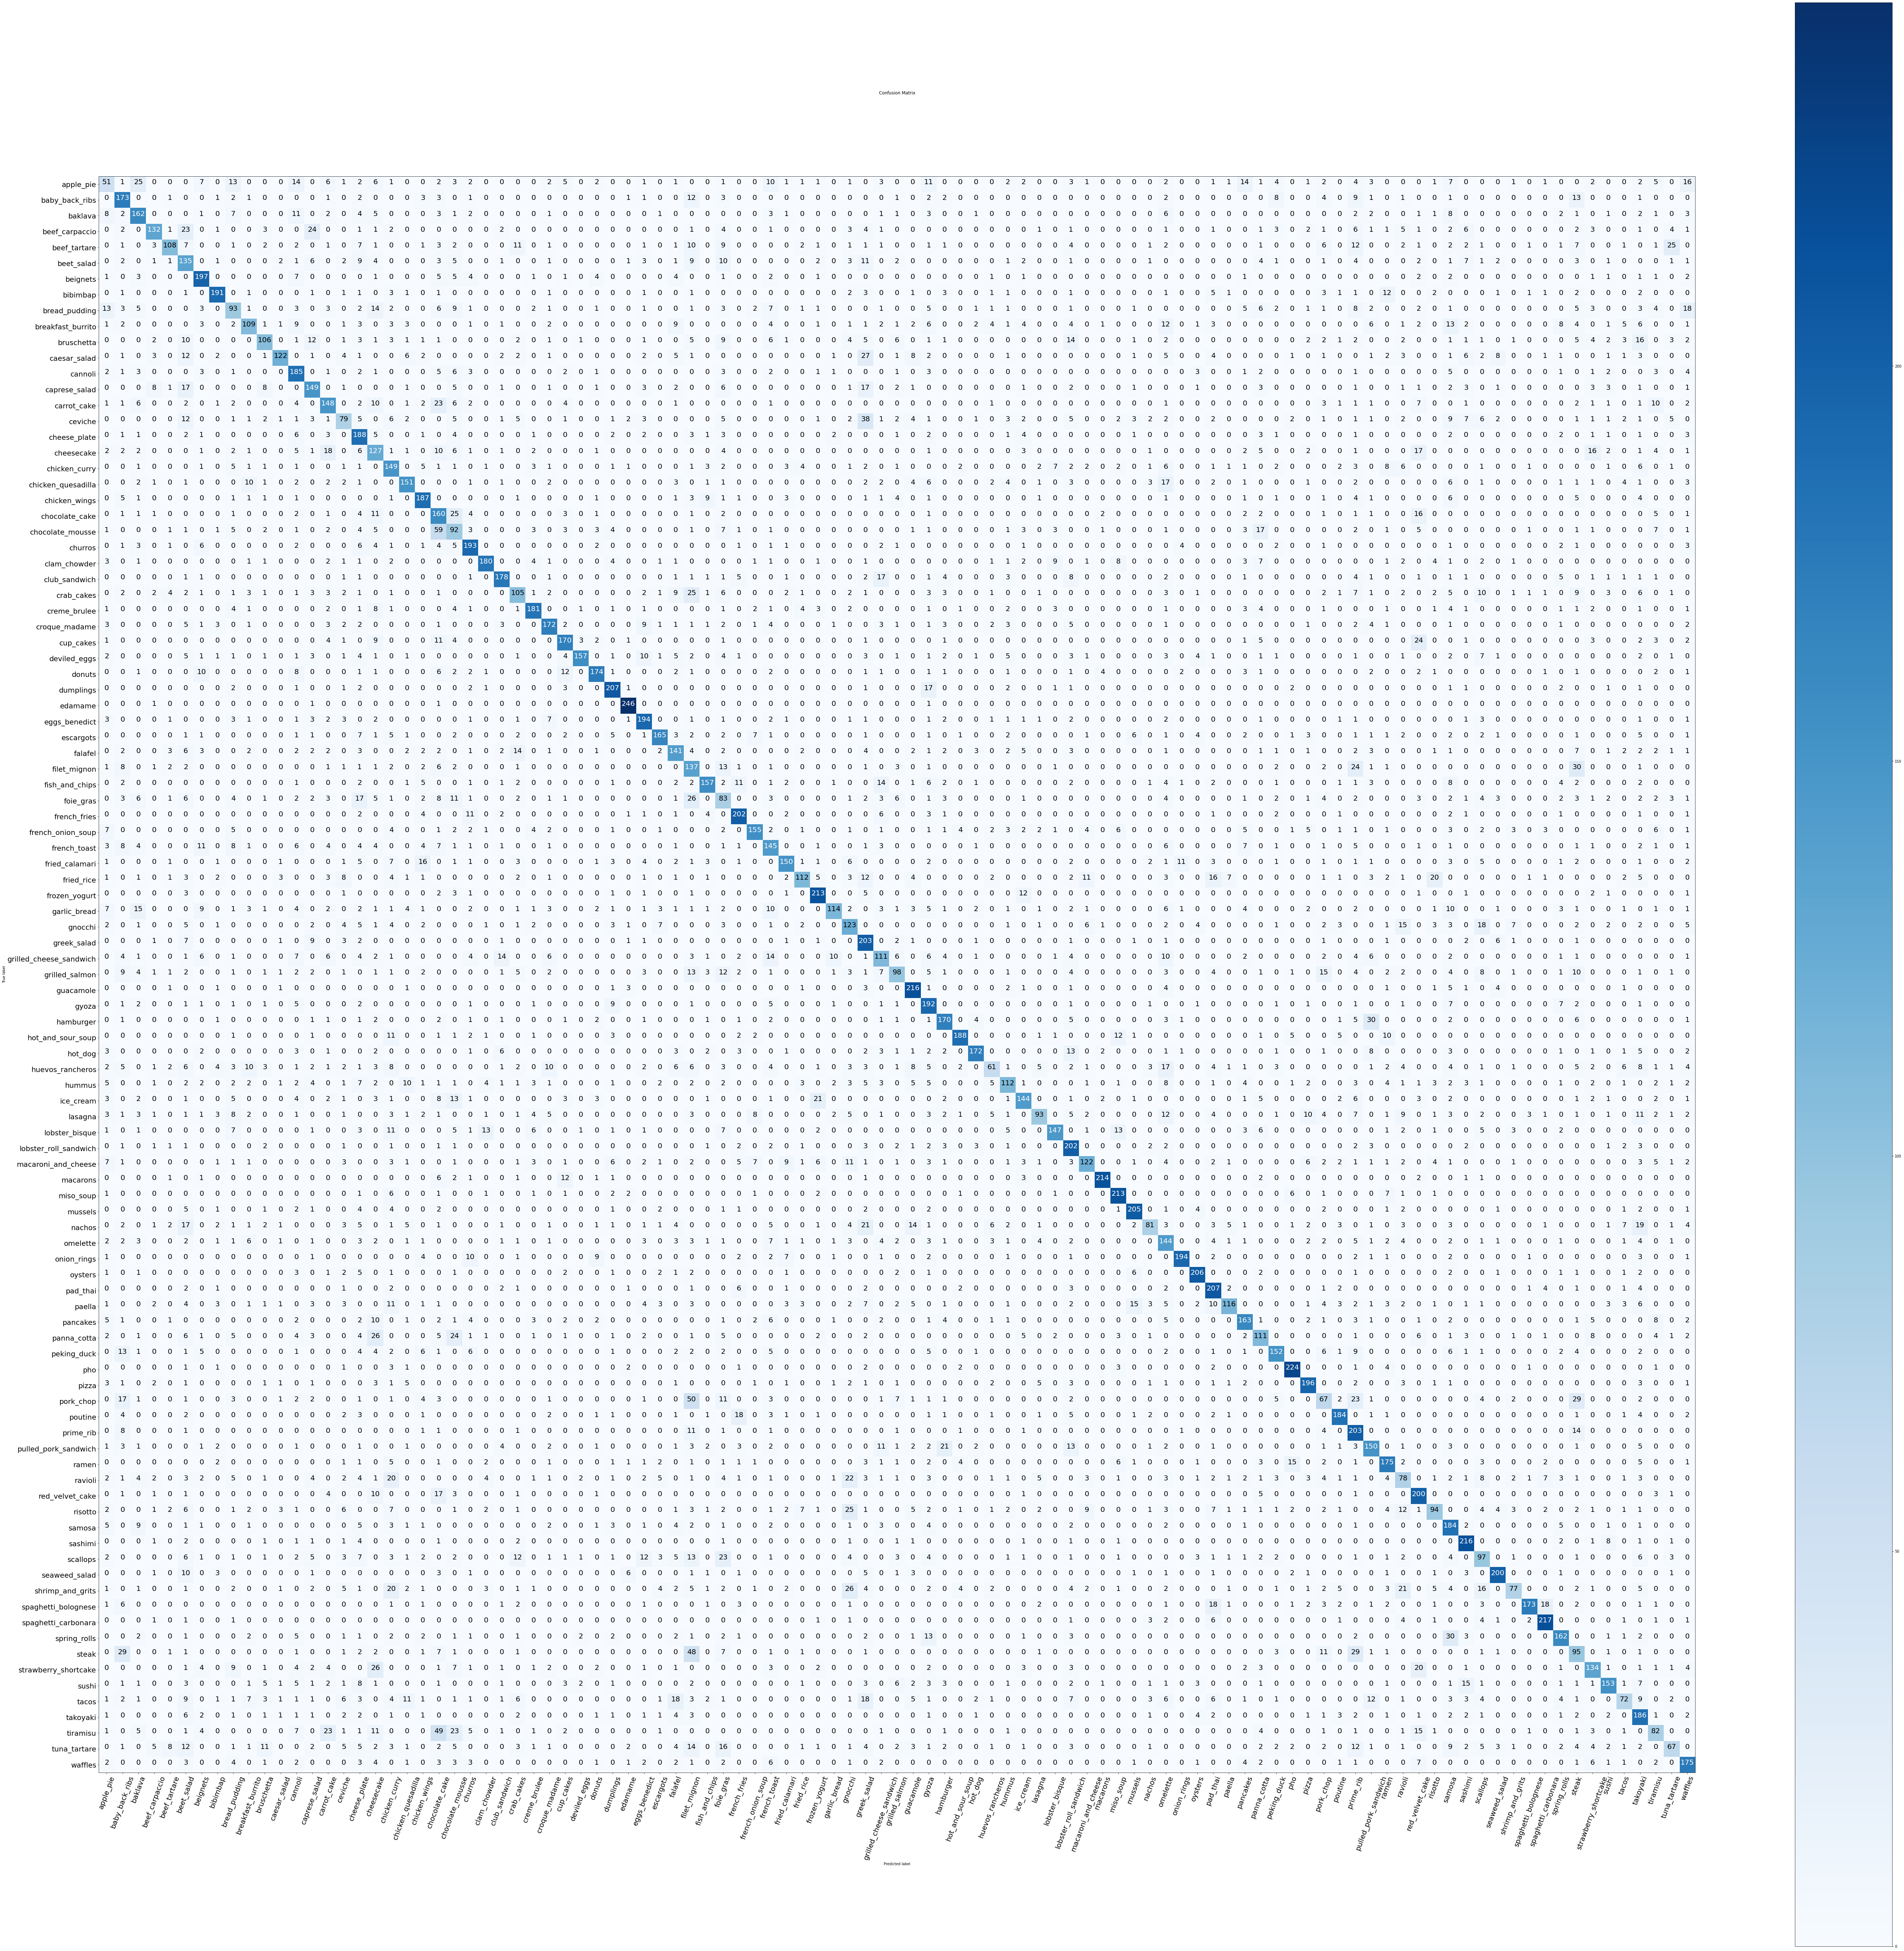

In [32]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

In [33]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_labels, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [34]:
cr_dict = classification_report(y_labels, y_pred, output_dict=True)
cr_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [35]:
# Plot F1 score for all classes
class_f1_scores = {}
for k,v in cr_dict.items():
    if k=="accuracy":
        break
    else:
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
sorted(class_f1_scores.items(), key=lambda x: x[1], reverse=True)

[('edamame', 0.9371428571428572),
 ('macarons', 0.895397489539749),
 ('pho', 0.8665377176015473),
 ('spaghetti_carbonara', 0.84765625),
 ('oysters', 0.8340080971659919),
 ('onion_rings', 0.832618025751073),
 ('mussels', 0.82),
 ('seaweed_salad', 0.8130081300813008),
 ('miso_soup', 0.8129770992366412),
 ('frozen_yogurt', 0.8114285714285714),
 ('hot_and_sour_soup', 0.8103448275862069),
 ('bibimbap', 0.7908902691511386),
 ('spaghetti_bolognese', 0.7881548974943051),
 ('dumplings', 0.7855787476280836),
 ('pizza', 0.7808764940239045),
 ('guacamole', 0.7783783783783783),
 ('sashimi', 0.7783783783783783),
 ('clam_chowder', 0.7708779443254817),
 ('hot_dog', 0.7644444444444444),
 ('french_fries', 0.7622641509433963),
 ('poutine', 0.7603305785123966),
 ('creme_brulee', 0.7494824016563146),
 ('deviled_eggs', 0.7476190476190476),
 ('donuts', 0.7357293868921776),
 ('club_sandwich', 0.734020618556701),
 ('eggs_benedict', 0.7238805970149255),
 ('beignets', 0.7229357798165138),
 ('escargots', 0.715835

In [36]:
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1":list(class_f1_scores.values())}).sort_values("f1", ascending=False)
f1_scores.reset_index(drop=True)
f1_scores.head(10)

class_names        f1
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

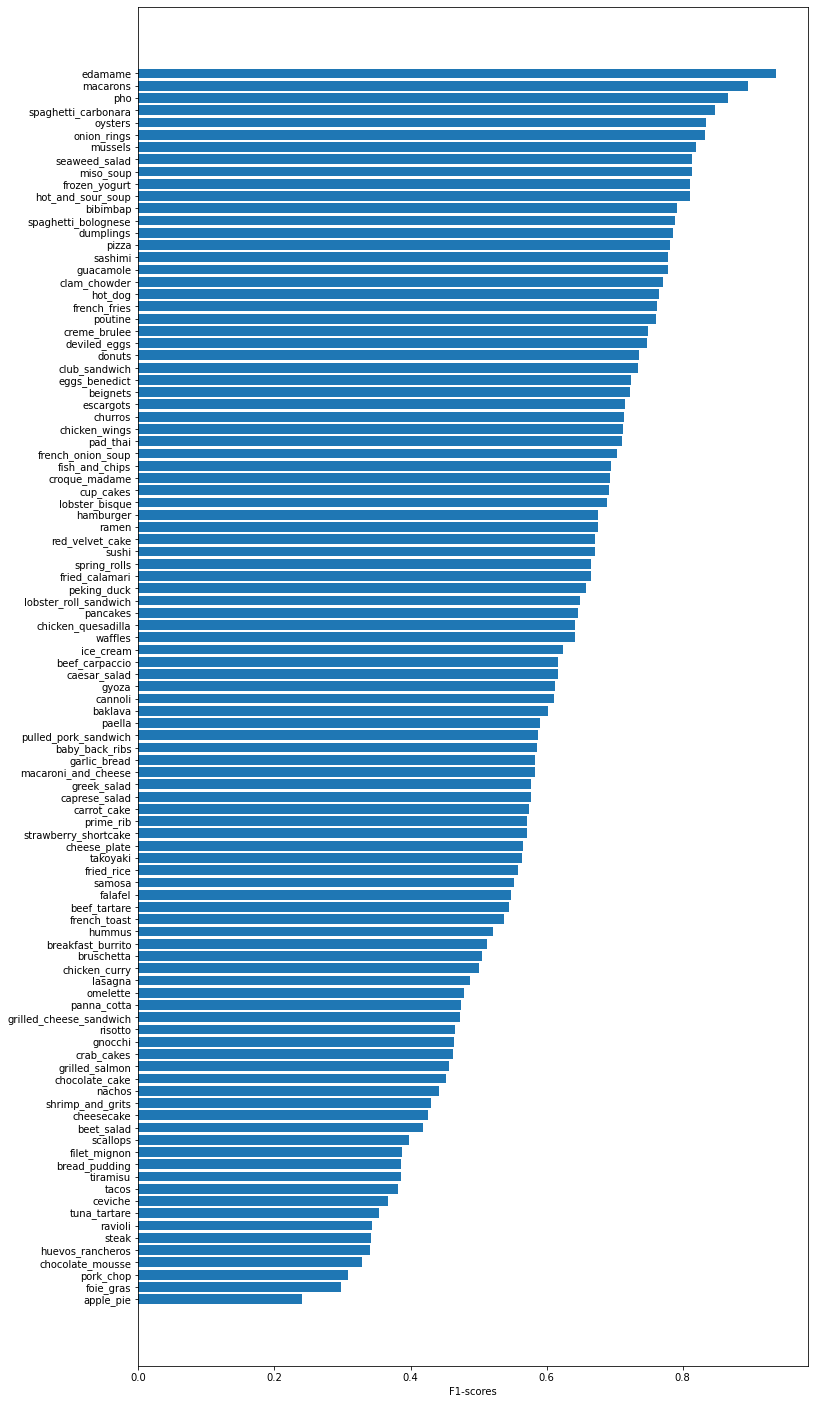

In [37]:
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-scores")
ax.invert_yaxis();

### Visualizing Predictions on test images

In [73]:
# Function to Load and Preprocess image

def load_image(filename, img_shape=224, scale=True):
    """
    Reads an image and preprocesses it

    Args:
        filename(str)
        img_shape (int)
        scale (bool)

    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    """

    # Read file
    img = tf.io.read_file(filename)

    # Decode image
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.resize(img, [img_shape, img_shape])

    if scale:
        return img/255.
    else:
        return img

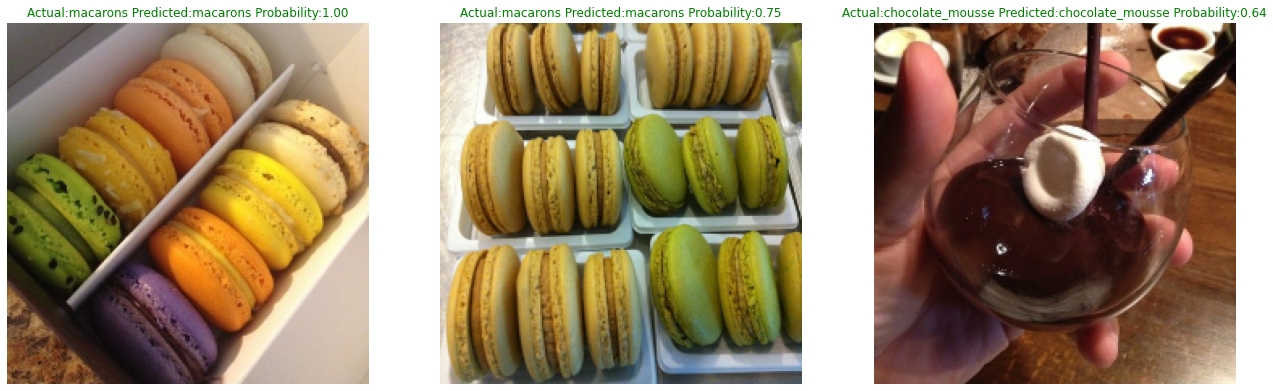

In [91]:
import os
import random

plt.figure(figsize=(22,10))
for i in range(3):
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/"+ class_name))
    filepath = test_dir + "/" + class_name + "/" + filename

    # Load image and make predictions
    img = load_image(filepath, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0), verbose=0)
    pred_class = class_names[pred_prob.argmax()]

    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Actual:{class_name} Predicted:{pred_class} Probability:{pred_prob.max():.2f}", c=title_color)
    plt.axis(False)

### Finding the Most Wrong predictions

1. Get all filepaths
2. Create DataFrame with filepaths, y_true, y_pred, pred_confidence
3. Extract samples which have incorrect predictions to new dataframe
4. Sort new dataframe with highest confidence appearing first
5. Visualize and compare the y_true and y_pred


In [95]:
# 1. Get all the file paths in test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy())
pred_classes = pred_probs.argmax(axis=1)
filepaths[:10], pred_classes[:10]

([b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
  b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
  b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
  b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
  b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
  b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
  b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
  b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
  b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
  b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg'],
 array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0]))

In [97]:
# 2. Create a DataFrame
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_confidence": pred_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_confidence y_true_classname      y_pred_classname  
0             0.847419        apple_pie                 gyoza  
1             0.964017        apple_pie             apple_pie  
2             0.959259        apple_pie             apple_pie  
3             0.658606        apple_pie  pulled_pork_sandwich  
4             0.367901        apple_pie             prime_rib  
...                ...              ...                   ...  
25245         0.972823          waffles               waffles  
25246         0.878028          waffles          cheese_plate  
25247         0.537900          waffles               waffles  
25248         0.501951          waffles  strawberry_shortcake  
25249         0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [98]:
# 3. Find wrong predictions 

pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_confidence y_true_classname      y_pred_classname  pred_correct  
0         0.847419        apple_pie                 gyoza         False  
1         0.964017        apple_pie             apple_pie          True  
2         0.959259        apple_pie             apple_pie          True  
3         0.658606        apple_pie  pulled_pork_sandwich         False  
4         0.367901        apple_pie             prime_rib         False

In [102]:
# 4. Sort DataFrame according to most wrong predictions

top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_confidence", ascending=False).reset_index(drop=True)[:100]
top_100_wrong.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/sc...      87      29   
1  b'/content/101_food_classes_10_percent/test/ap...       0     100   
2  b'/content/101_food_classes_10_percent/test/lo...      61      53   
3  b'/content/101_food_classes_10_percent/test/st...      94      83   
4  b'/content/101_food_classes_10_percent/test/sa...      85      92   

   pred_confidence       y_true_classname y_pred_classname  pred_correct  
0         0.999997               scallops        cup_cakes         False  
1         0.999995              apple_pie          waffles         False  
2         0.999988  lobster_roll_sandwich        hamburger         False  
3         0.999987   strawberry_shortcake  red_velvet_cake         False  
4         0.999981                 samosa     spring_rolls         False

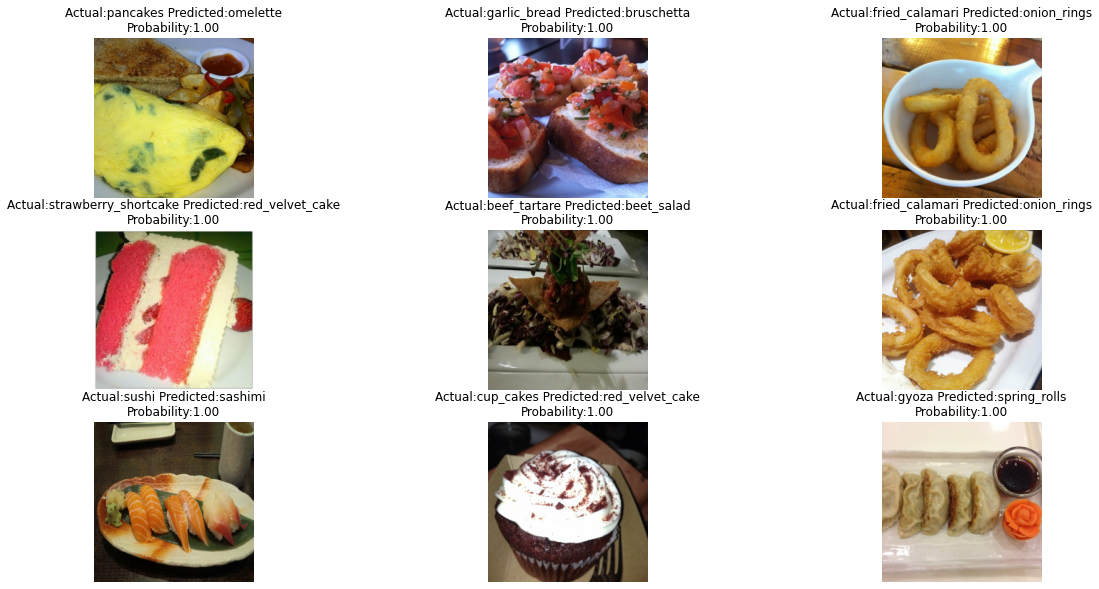

In [107]:
# 5. Visualize the images with highest confidence but wrong
images_to_view = 9
start_index = 10
plt.figure(figsize=(20, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_image(row[1], scale=False)
    _, _, _, _, pred_prob, y_true, y_pred, _ = row
    plt.imshow(img/255.)
    plt.title(f"Actual:{y_true} Predicted:{y_pred}\nProbability:{pred_prob:.2f}")
    plt.axis(False)

## Prediction with Custom Images

In [108]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2023-02-03 18:28:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 142.250.152.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  67.3MB/s    in 0.2s    

2023-02-03 18:28:39 (67.3 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [111]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg']

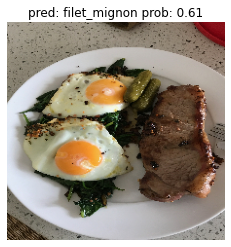

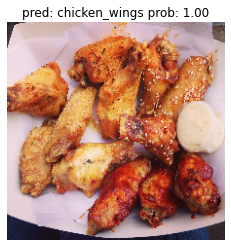

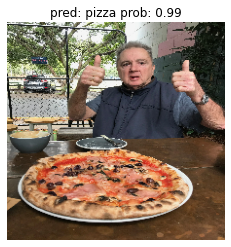

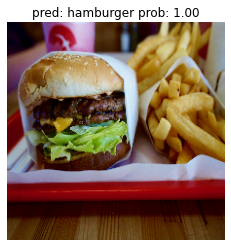

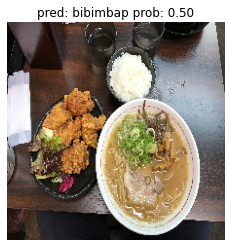

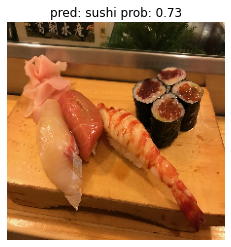

In [113]:
for img in custom_food_images:
    img = load_image(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0), verbose=0)
    pred_class = class_names[pred_prob.argmax()]

    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"pred: {pred_class} prob: {pred_prob.max():.2f}")
    plt.axis(False)